## Dependencies

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Choice of dataset

The first possible dataset is **permuted MNIST**. The model will be trained on different variations of the same dataset. Each variation corresponds to a different classification task as stated in the paper. The permuted MNIST dataset consists in fist flattening the black and white images of hand written digits and applying a random permutation to the whole dataset of flattened pixel data vectors.

The second possible dataset is **rotated MNIST**. Each variation corresponds to MNIST rotated by $ 10(i-1)$ degree if $i$ is the index of the variation/task.

In [3]:
BATCH_SIZE = 128
VAL_FRAC   = 0.1
DEBUG      = True # Accelerates training by ~90% by only uses 10% of training dataset.
                   # Switch off for generating figures, switch on for testing code.

def take_subset(dataset, frac):
    subset_size = int(frac * len(dataset))
    indices = torch.randperm(len(dataset))[:subset_size]
    return Subset(dataset, indices)

def generate_permuted_mnist(i):
    """
    Generates a permuted MNIST dataset with random permutation
    
    author = Jules
    """

    # Define transform
    TRANSFORM = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
    ])

    # load dataset
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)

    # Permute dataset splits
    permutation = torch.randperm(28 * 28)
    raw_dataset.data = raw_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    test_dataset.data = test_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    
    return raw_dataset, test_dataset

def generate_rotated_mnist(i):
    """
    Generates a rotated MNIST dataset

    author = Pierre
    """

    # Define transform
    TRANSFORM = transforms.Compose([transforms.ToTensor()])

    # Load datasets
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)

    # Rotate dataset splits
    angle = i * 36 # Define the rotation angle in degrees

    def rotate_dataset(dataset, angle):
        rotated_data = []
        for j in range(len(dataset)):
            img, label = dataset[j]
            img = transforms.functional.rotate(img, angle) # Rotate image
            img = img.view(-1)
            rotated_data.append((img, label))
        return rotated_data

    raw_dataset = rotate_dataset(raw_dataset, angle)
    test_dataset = rotate_dataset(test_dataset, angle)

    return raw_dataset, test_dataset


def generate_tasks(n_tasks, dataset_gen):
    """
    Used to generate N dataloaders corresponding to N different tasks.
    Training dataset is split into training and validation.

    author = Jules
    """

    raw_datasets = []
    test_datasets = []

    # Generate datasets
    for i_task in range(n_tasks):
        raw_dataset, test_dataset = dataset_gen(i_task)

        # DEBUG CODE
        if DEBUG:
            raw_dataset = take_subset(raw_dataset, 0.5)
            test_dataset = take_subset(test_dataset, 0.5)

        raw_datasets.append(raw_dataset)
        test_datasets.append(test_dataset)

    train_loaders = []
    val_loaders = []
    test_loaders = []

    # Generate dataloaders
    for i_task in range(n_tasks):
        raw_dataset = raw_datasets[i_task]
        test_dataset = test_datasets[i_task]

        # Split train into train and validation
        val_size = int(VAL_FRAC * len(raw_dataset))
        train_size = len(raw_dataset) - val_size
        torch.manual_seed(42)  # make sure epochs have the same validation dataset
        train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [train_size, val_size])

        # Turn into data loaders
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        print(f'Task {i_task + 1} Splits: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test')

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
        test_loaders.append(test_loader)

    return train_loaders, val_loaders, test_loaders


## Util Functions

### Validation

Appendix 4.1 suggests figure 3B was realized using early stopping, which requires the use of a validation split. For this reason, we split the training dataset into a validation and training dataset. Early stopping is as follows in the paper: if validation is seen increasing 5 consecutive times (arbitrary threshold), training is stopped and the model performing the best on previous epochs is kept. This requires to periodically save the dataset and load again the best performing model at the end of the training function.

Validation dataset is used to compute the validation loss, however the test set is used to compute the test accuracy (or `Fraction correct` in the paper).

In [4]:
def evaluate_accuracy(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: torch.device,
):
    """
    Evaluate test accuracy of the given model on the test split
    """

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [5]:
def validate_epoch(
    model: torch.nn.Module,
    val_dataloader: DataLoader,
    criterion,
    device: torch.device,
    early_stopping = False
):
    """
    This function validates the model on the validation dataset.
    """

    val_loss = 0.0
    model = model.to(device)
    model.eval()
    count_increase = 0
    previous_loss = -1
    best_model = None
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # do the forward pass
            output = model(data)

            # compute the loss
            try:    #Case of EWC
                loss = criterion(output, target, model)
            except TypeError:
                loss = criterion(output, target)

            # print statistics
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

### Training Functions

In [6]:
def train_epoch(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    device: torch.device,
):
    """
    Training function. Loads the batch, perform forward pass, compute gradients and perform backward pass.
    Only difference is that you can pass the loss function as an argument.
    This allows to use a simple cross entropy loss function, or a more complex one including L2 or EWC regularization.
    """

    train_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        try:    # For EWC
            loss = criterion(output, target, model)
        except TypeError:
            loss = criterion(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def fit(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    criterion,
    epochs: int,
    device: torch.device,
    early_stopping = False
):
    """
    The fit method calls the train_epoch() method for a specified
    number of epochs and returns the train and validation losses.
    """

    global N_TASKS

    # keep track of losses and accuracies
    train_losses = []
    val_losses = []
    count_increase = 0
    best_model = None   # For early stopping
    for epoch in range(epochs):

        t = time() # current time

        # train function
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        train_losses.append(train_loss)

        # validate epoch
        val_loss = validate_epoch(
            model=model,
            val_dataloader=val_dataloader,
            criterion=criterion,
            device=device,
            early_stopping=early_stopping
        )

        if early_stopping and len(val_losses) >0 and val_loss > max(val_losses):
            best_model = model.state_dict()

        if early_stopping and epoch > 0:
            if val_loss > val_losses[-1]:
                count_increase += 1
                if count_increase == 5:
                    print(f"Early stopping at epoch {epoch + 1}")
                    # We reset the weights to the best epoch in terms of validation error
                    model.load_state_dict(best_model)
                    return train_losses, val_losses
            else:
                count_increase = 0

        val_losses.append(val_loss)

        # step scheduler if needed
        if scheduler != None:
            scheduler.step()

        dt = time() - t # time difference
        print(f"Epoch [{epoch + 1}/{epochs}]: train={round(train_loss, 4)} val={round(val_loss, 4)}, ({round(dt, 2)}s)")

    return train_losses, val_losses


## EWC loss function

In [7]:
from copy import deepcopy

class EWC(object):
    def __init__(self, model, dataset: list):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data

        self.model.eval()
        for batch_idx, (data, target) in enumerate(self.dataset):
            data, target = data.to(device), target.to(device)
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, new_model):
        loss = 0
        for n, p in new_model.named_parameters():
            _loss = 1/2 *self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

def generate_ewc_loss(penalties, lambda_regul):
    """
    Generates an EWC loss function given list of penalties to apply (instances of EWC class)
    and value of regularization parameter lambda.
    
    author = Pierre
    """

    def ewc_loss_function(output, target, new_model):
        loss = F.cross_entropy(output, target)
        #print(f'raw loss = {loss}')
        for penalty in penalties:
            loss += lambda_regul * penalty(new_model)
            #print(f'   raw penalty = {raw_penalty}')
        return loss

    return ewc_loss_function

## Model architecture

In [8]:
class SmallNet(torch.nn.Module):
    def __init__(self, width_hidden_layers = 400):
        super(SmallNet, self).__init__()

        self._input_size = 28 * 28
        self._n_ff      = width_hidden_layers
        self._n_output   = 10
        self._do_input   = 0.2
        self._do_ff      = 0.5

        self.do0 = torch.nn.Dropout(self._do_input)

        self.ff1 = torch.nn.Linear(self._input_size, self._n_ff)
        self.do1 = torch.nn.Dropout(self._do_ff)

        self.ff2 = torch.nn.Linear(self._n_ff, self._n_ff)
        self.do2 = torch.nn.Dropout(self._do_ff)

        self.ff7 = torch.nn.Linear(self._n_ff, self._n_output)

    def forward(self, x):

        # input dropout of 20% as stated in paper
        x = self.do0(x)

        # dense FF hidden layers, each with 50% dropout and ReLU activation
        # dropout is generally placed after the activation
        x = self.do1(F.relu(self.ff1(x)))
        x = self.do2(F.relu(self.ff2(x)))

        # classification layer
        x = self.ff7(x)

        return x

print("Model Parameters: ", sum(p.numel() for p in SmallNet().parameters()))

Model Parameters:  478410


## Grid Search for learning rate and width of hidden layer

In [ ]:
from sklearn.model_selection import ParameterGrid
N_EPOCHS = 10

# Define the parameter grid
param_grid = {
    #'lr': np.logspace(-5, -3, 10),
    'width_hidden_layer': np.linspace(400, 2000, 10).astype(int)
}

width_hidden_layer = 800
lr=0.001
# Initialize variables to store the best parameters and the best validation loss
best_params = None
best_val_loss = float('inf')

# Perform grid search
for params in ParameterGrid(param_grid):

    #lr = params['lr']
    width_hidden_layer = params['width_hidden_layer']
    print("Learning rate :", lr, '; Width layer :', width_hidden_layer)
    # Initialize model with the current width_hidden_layer
    model = SmallNet(width_hidden_layers=width_hidden_layer)
    model.to(device)

    # Define optimizer with the current learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = F.cross_entropy

    # Train the model
    train_dataloader, val_dataloader, _ = generate_tasks(1, generate_permuted_mnist)
    train_losses, val_losses = fit(
        model=model,
        train_dataloader=train_dataloader[0],
        val_dataloader=val_dataloader[0],
        optimizer=optimizer,
        scheduler=None,
        criterion=criterion,
        epochs=N_EPOCHS,
        device=device,
        early_stopping=True
    )

    # Get the validation loss of the last epoch
    val_loss = val_losses[-1]

    # Update the best parameters if the current validation loss is lower
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f'Best parameters: {best_params}')
print(f'Best validation loss: {best_val_loss}')

Learning rate : 0.001 ; Width layer : 400
Task 1 Splits: 5400 train, 600 val, 1000 test
Epoch [1/10]: train=2.3033 val=2.3009, (0.8s)
Epoch [2/10]: train=2.302 val=2.2998, (0.8s)
Epoch [3/10]: train=2.3001 val=2.2987, (1.0s)
Epoch [4/10]: train=2.2991 val=2.2976, (0.8s)
Epoch [5/10]: train=2.2987 val=2.2965, (0.7s)
Epoch [6/10]: train=2.298 val=2.2953, (0.6s)
Epoch [7/10]: train=2.296 val=2.2942, (0.6s)
Epoch [8/10]: train=2.2959 val=2.2931, (0.6s)
Epoch [9/10]: train=2.2932 val=2.2919, (0.7s)
Epoch [10/10]: train=2.2923 val=2.2908, (0.6s)
Learning rate : 0.001 ; Width layer : 577
Task 1 Splits: 5400 train, 600 val, 1000 test
Epoch [1/10]: train=2.305 val=2.3033, (0.7s)
Epoch [2/10]: train=2.3027 val=2.3018, (0.6s)
Epoch [3/10]: train=2.3022 val=2.3003, (0.7s)
Epoch [4/10]: train=2.301 val=2.2988, (0.7s)
Epoch [5/10]: train=2.3002 val=2.2973, (0.6s)
Epoch [6/10]: train=2.2962 val=2.2958, (0.6s)
Epoch [7/10]: train=2.2959 val=2.2943, (0.6s)
Epoch [8/10]: train=2.2948 val=2.2928, (0.6s)


## Training Script

The training script generates $N$ different tasks and calls the `fit(..)` function as many times on different tasks. It then saves the curves and model obtained. It has to be ran multiple times with different loss functions to generate subfigure 2A

No scheduler seems to have been used in the paper, so we are not using any here.

In [9]:
#################################################################################
# N_EPOCHS    = Number of epochs per task.
# N_TASKS     = Number of tasks to train the model on.
# DATASET_GEN = Type of tasks. We can choose between permuted MNIST and rotated MNIST
# REGUL_TYPE  = Type of regularization. Very important for the paper, as it changes the training process.
#               - `SGD` | Classic SGD with no regularization term
#               - `L2`  | SGD with L2 regularization term
#               - `EWC` | SGD with elastic weight consolidation regularization
#################################################################################
N_TASKS     = 10
DATASET_GEN = generate_permuted_mnist

train_dataloaders, val_dataloaders, test_dataloaders = generate_tasks(N_TASKS, DATASET_GEN)

Task 1 Splits: 27000 train, 3000 val, 5000 test
Task 2 Splits: 27000 train, 3000 val, 5000 test
Task 3 Splits: 27000 train, 3000 val, 5000 test
Task 4 Splits: 27000 train, 3000 val, 5000 test
Task 5 Splits: 27000 train, 3000 val, 5000 test
Task 6 Splits: 27000 train, 3000 val, 5000 test
Task 7 Splits: 27000 train, 3000 val, 5000 test
Task 8 Splits: 27000 train, 3000 val, 5000 test
Task 9 Splits: 27000 train, 3000 val, 5000 test
Task 10 Splits: 27000 train, 3000 val, 5000 test


In [11]:
N_EPOCHS = 30

for REGUL_TYPE in [ "EWC"]:
    print('================================================')
    print(REGUL_TYPE)
    
    # Initialize model
    model = SmallNet(width_hidden_layers=2000)
    model.to(device)

    # Loss, optimizer and scheduler
    if REGUL_TYPE == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        criterion = F.cross_entropy
    elif REGUL_TYPE == 'EWC':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    else:
        raise Exception('Invalid regularization')

    full_test_accuracies = []
    penalties_ewc = []
    for i_task in range(N_TASKS):

        # Get tasks
        train_dataloader = train_dataloaders[i_task]
        val_dataloader = val_dataloaders[i_task]

        print(f'Training on task {i_task + 1}...')

        if REGUL_TYPE == 'EWC':
            penalties_ewc.append(EWC(model, dataset=train_dataloader).penalty) # Add one regularization per task, as proposed by Kirkpatrick et al.
            criterion = generate_ewc_loss(penalties_ewc, 100) # Need to redefine the loss function with the fisher of the former task

        # Fit on task
        train_losses, val_losses = fit(
            model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            optimizer=optimizer,
            scheduler=None,
            criterion=criterion,
            epochs=N_EPOCHS,
            device=device,
            early_stopping=True,
        )

        # After training on n_tasks, we evaluate the model on all the tasks it learnt.
        if i_task >= 1:  # At least two tasks learnt
            test_dataloader = DataLoader(torch.utils.data.ConcatDataset([test_dataloaders[j].dataset for j in range(i_task + 1)]))
            full_test_accuracies.append(evaluate_accuracy(model, test_dataloader, device))

        print( full_test_accuracies)

    # Save model and metrics
    np.save(f'2b_{REGUL_TYPE}_test_accuracy.npy', np.array(full_test_accuracies))

print('Done!');

EWC
Training on task 1...
Epoch [1/30]: train=2.2985 val=2.2856, (5.99s)
Epoch [2/30]: train=2.2809 val=2.2667, (5.38s)
Epoch [3/30]: train=2.2634 val=2.2477, (4.13s)
Epoch [4/30]: train=2.2456 val=2.2278, (5.8s)
Epoch [5/30]: train=2.2281 val=2.2069, (6.94s)
Epoch [6/30]: train=2.2085 val=2.1844, (6.43s)
Epoch [7/30]: train=2.1866 val=2.1598, (5.94s)
Epoch [8/30]: train=2.1641 val=2.1328, (5.04s)
Epoch [9/30]: train=2.1403 val=2.1029, (5.29s)
Epoch [10/30]: train=2.1119 val=2.0694, (5.6s)
Epoch [11/30]: train=2.0816 val=2.0321, (5.72s)
Epoch [12/30]: train=2.0475 val=1.9904, (5.78s)
Epoch [13/30]: train=2.0071 val=1.9434, (5.37s)
Epoch [14/30]: train=1.9642 val=1.8912, (5.37s)
Epoch [15/30]: train=1.9148 val=1.8335, (5.93s)
Epoch [16/30]: train=1.8596 val=1.7702, (5.87s)
Epoch [17/30]: train=1.7997 val=1.7018, (5.81s)
Epoch [18/30]: train=1.7371 val=1.6293, (5.77s)
Epoch [19/30]: train=1.6662 val=1.5533, (5.14s)
Epoch [20/30]: train=1.5964 val=1.4759, (5.79s)
Epoch [21/30]: train=1.52

KeyboardInterrupt: 

## Generate Figure 2B

Follow these steps to generate figure 2B. You can then redo all these steps after changing the dataset from permuted to rotated MNIST using the option `DATASET_GEN`.
The regularization technique used can be chosen by changing the option `REGUL_TYPE`. Each reg technique will save their respective train accuracy curves to different files.


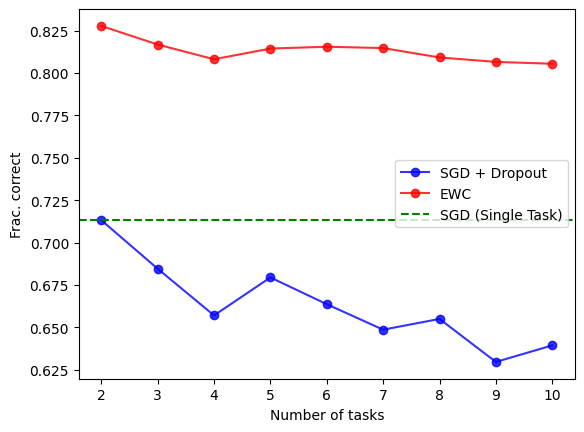

In [12]:
FILE_NAMES = [
    'SGD',
    'EWC',
]
color_dict = {'SGD':"blue",
              #'SGD_one_task': 'black',
              'EWC':'red'}
legend_dict = {'SGD':'SGD + Dropout',
                #'SGD_one_task': 'Single task performance',
                'EWC':'EWC'}

for file_name in FILE_NAMES:
    test_accuracy = np.load(f'2b_{file_name}_test_accuracy.npy')
    plt.plot(range(2, N_TASKS +1), test_accuracy, label=legend_dict[file_name], color = color_dict[file_name], alpha = 0.8, marker = 'o')

sgd_single_task_perf = np.load(f'2b_SGD_test_accuracy.npy')[0]

plt.axhline(y=sgd_single_task_perf, color='g', linestyle='--', label='SGD (Single Task)')

plt.ylabel('Frac. correct')
plt.xlabel('Number of tasks')
plt.legend()

plt.show()